In [15]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
import scipy.integrate as scint
from astropy.modeling import models, fitting
import matplotlib
from scipy.interpolate import UnivariateSpline


import sys
sys.path.insert(0, '/users/milan/nudetect')
import nudetect

In [2]:
CIT2921 = nudetect.Source("Am241", 2921)

In [36]:
h119_Am241 = nudetect.GammaFlood("floodAm241_5C_-500V_20190815_small_region_cap_try3.fits",
                                 detector="H119",
                                 source = CIT2921,
                                 voltage = 500,
                                 temp=5,
                                 data_dir='Am241_small_region_capoffset/data',
                                 plot_dir='Am241_small_region_capoffset/plots'
                                )

In [37]:
h119_Am241.load_raw_data()

In [38]:
h119_Am241.gen_count_map()

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint32)

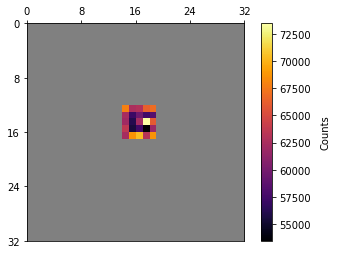

In [39]:
h119_Am241.plot_pixel_map('Count')
#h119_Am241.plot_pixel_hist('Count')

In [257]:
other_data, other_data_2d = nudetect.fits_to_df("floodAm241_5C_-500V_20190815_small_region_cap_try3.fits",
                                   ["GRADE","PH_RAW","PH_OFF", "PH_COM", "PH_TR"],
                                   pos=0)
tp_mask = (h119_Am241.raw_data_1d['STIM'] == 1)
grade_mask = (other_data['GRADE'] == 0)
bad_pix_mask = (h119_Am241.raw_data_1d['RAWX'] == 17) & (h119_Am241.raw_data_1d['RAWY'] == 14)

In [41]:
%%time
h119_Am241.gen_quick_gain(plot_subdir='gamma_pix', misc_mask=~(tp_mask | bad_pix_mask) & grade_mask)

/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4

CPU times: user 1min 37s, sys: 116 ms, total: 1min 37s
Wall time: 1min 38s


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0)

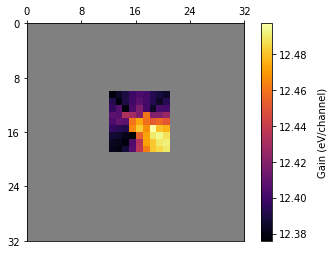

In [42]:
h119_Am241.plot_pixel_map('Gain')

In [43]:
%%time
h119_Am241.gen_spectrum(misc_mask=~(tp_mask | bad_pix_mask) & grade_mask)

CPU times: user 1min 59s, sys: 673 ms, total: 2min
Wall time: 2min 3s


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 2.00000000e+00],
       [1.59995000e-02, 2.79985000e-02, 3.99975000e-02, ...,
        1.19970002e+02, 1.19982001e+02, 1.19994000e+02]])

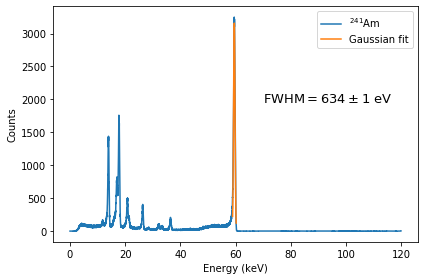

In [44]:
h119_Am241.plot_spectrum(fit_below=50, fit_above=60)

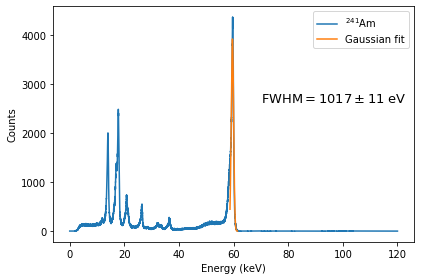

In [16]:
# no mask
h119_Am241.gen_quick_gain(save_plot=False, save_data=False)
h119_Am241.gen_spectrum(save_data=False)
h119_Am241.plot_spectrum(save_plot=False)

In [24]:
from matplotlib.colors import LogNorm

In [46]:
clean_grade0_spectrum = h119_Am241.spectrum

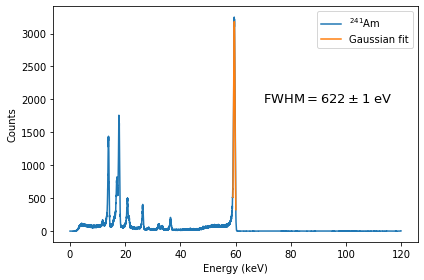

In [47]:
h119_Am241.plot_spectrum(spectrum=clean_grade0_spectrum, fit_below=40, fit_above=50)

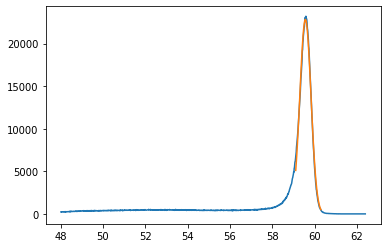

In [264]:
plt.plot(clean_grade0_spectrum[1][4000:5200], clean_grade0_spectrum[0][4000:5200])
plt.plot(clean_grade0_spectrum[1][4925:5025], line(clean_grade0_spectrum[1][4925:5025]))

In [21]:
clean_grade0_spectrum[0].argmax()

4974

In [254]:
line_init = models.Gaussian1D(amplitude=22000, mean=59.7, stddev=0.8)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][4925:5025], clean_grade0_spectrum[0][4925:5025])

In [255]:
line.stddev * 2.355

0.6229666673634122

In [59]:
spline = UnivariateSpline(clean_grade0_spectrum[1][4930:5000],
                          clean_grade0_spectrum[0][4930:5000] - clean_grade0_spectrum[0][4930:5000].max()/2, s=0.001)
roots = spline.roots() # find the roots

In [60]:
roots[1] - roots[0]

0.6072214623800889

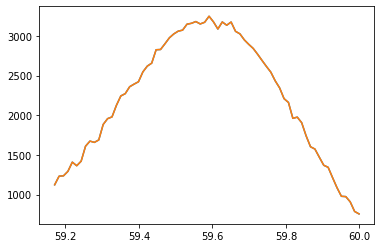

In [105]:
plt.plot(clean_grade0_spectrum[1][4930:5000], clean_grade0_spectrum[0][4930:5000])
plt.plot(clean_grade0_spectrum[1][4930:5000], spline(clean_grade0_spectrum[1][4930:5000]) + clean_grade0_spectrum[0].max()/2)

In [201]:
spline.roots()

array([59.25736209, 59.87291564, 59.99129095, 59.99687482])

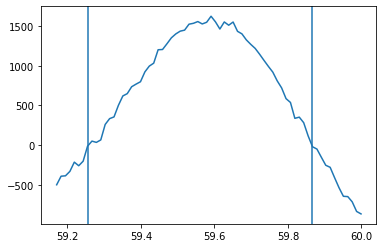

In [106]:
plt.plot(clean_grade0_spectrum[1][4930:5000], spline(clean_grade0_spectrum[1][4930:5000]))
for r in spline.roots():
    plt.axvline(r)

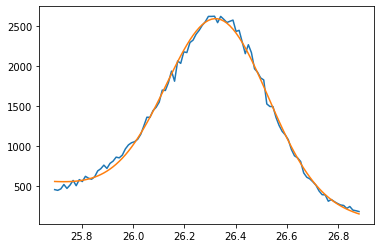

0.4677711677789126
2140


In [365]:
upper=2240
lower=2140

line_init = models.Gaussian1D(amplitude=3000, mean=26, stddev=0.8) + models.Linear1D(slope=-0.001, intercept=100)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()
print(line.stddev_0*2.355)

0.5157764570921799


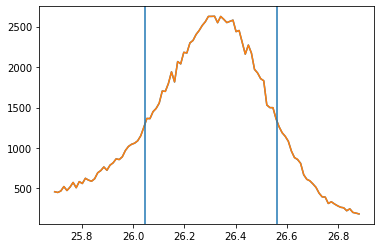

In [370]:
spline = UnivariateSpline(clean_grade0_spectrum[1][lower:upper],
                          clean_grade0_spectrum[0][lower:upper] - clean_grade0_spectrum[0][lower:upper].max()/2)
roots = spline.roots() # find the roots
print(roots[1] - roots[0])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], spline(clean_grade0_spectrum[1][lower:upper]) + clean_grade0_spectrum[0][lower:upper].max()/2)
plt.axvline(roots[0])
plt.axvline(roots[1])

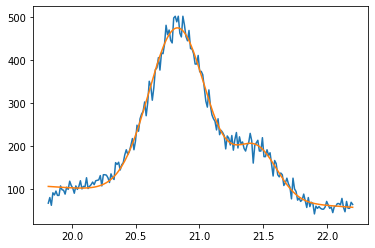

0.5315547201489141


In [150]:
upper=1850
lower=1650

line_init = models.Gaussian1D(amplitude=500, mean=20.7, stddev=0.4) + models.Linear1D(slope=-1, intercept=100) + \
    models.Gaussian1D(amplitude=200, mean=21.5, stddev=0.4)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()
print(line.stddev_0*2.355)

In [132]:
clean_grade0_spectrum[1][5000]

60.0109995

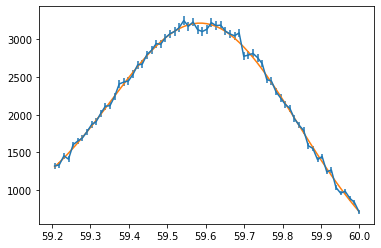

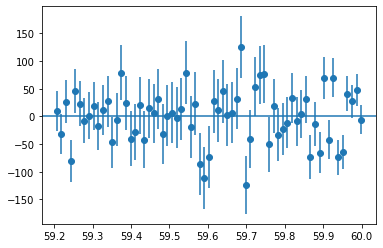

1.1330098477580166


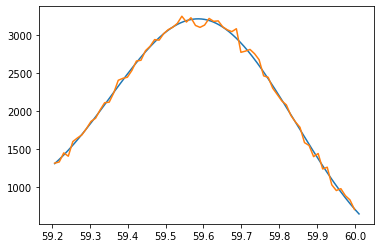

0.6098621294271211


In [120]:
lower=4933
upper=5000
fwhm_60, line_60 = fit_line(clean_grade0_spectrum, lower=4933, upper=5000,
                                  plot=True, intercept=50, slope=-10)

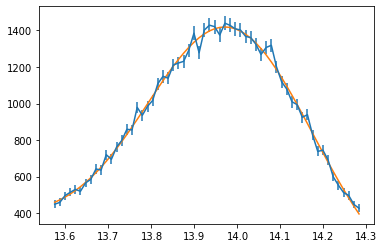

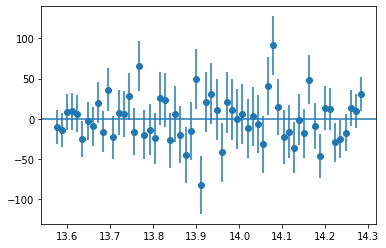

0.8248434023880301


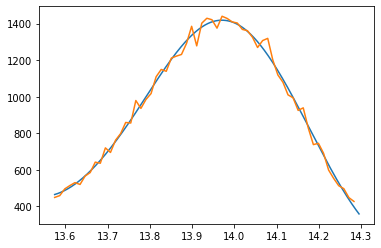

0.5000777060397823


In [121]:
fwhm_14, line_14 = fit_line(clean_grade0_spectrum, lower=1130, upper=1190, energy=13.95,
                                  plot=True, intercept=50, slope=-10)

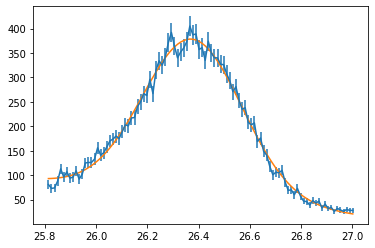

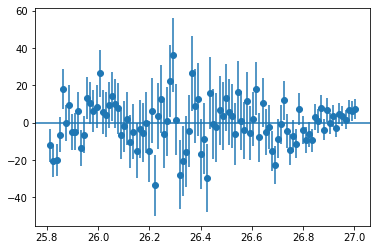

0.9063607141764092


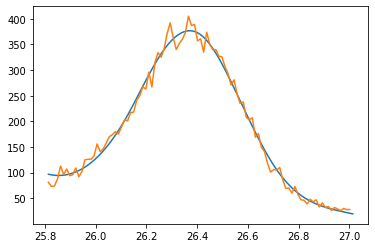

0.51971684460867


In [236]:
fwhm_26, line_26 = fit_line(clean_grade0_spectrum, lower=2150, upper=2250, energy=26,
                                  plot=True, intercept=50, slope=-10)

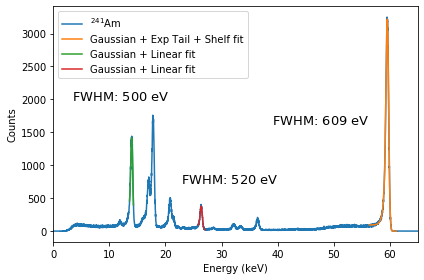

In [239]:
plt.plot(clean_grade0_spectrum[1], clean_grade0_spectrum[0], label='${}^{241}$Am')
plt.plot(clean_grade0_spectrum[1][4700:5100], line_60(clean_grade0_spectrum[1][4700:5100]), label='Gaussian + Exp Tail + Shelf fit')
plt.plot(clean_grade0_spectrum[1][1130:1190], line_14(clean_grade0_spectrum[1][1130:1190]), label='Gaussian + Linear fit')
plt.plot(clean_grade0_spectrum[1][2150:2250], line_26(clean_grade0_spectrum[1][2150:2250]), label='Gaussian + Linear fit')
plt.text(0.6, 0.5, f'FWHM: ${fwhm_60*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.text(0.05, 0.6, f'FWHM: ${fwhm_14*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.text(0.35, 0.25, f'FWHM: ${fwhm_26*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.legend()
#plt.title('Full Frame Spectrum, Single Pixel Events Only')
plt.xlim(0,65)
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.savefig('energy_spectrum_floodAm241_5C_-500V_20190815_small_region_capoffset.pdf')

In [54]:
line

<CompoundModel1(amplitude_0=2976.06598692, mean_0=59.59927222, stddev_0=0.24211418, slope_1=-697.73921459, intercept_1=41818.91337098)>

In [61]:
line.stddev_0*1000*2*np.sqrt(2*np.log(2))

570.1353145040584

In [57]:
2.355*1000*np.sqrt(fit_line.fit_info['cov_x'][2,2]*((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2).sum()/(len(line(clean_grade0_spectrum[1][lower:upper])) - 5))

15.397515979571912

In [56]:
np.sqrt(fit_line.fit_info['param_cov'][2,2])*1000*2*np.sqrt(2*np.log(2))

15.396339393792056

In [14]:
def pixel_mask(x, y):
    return (h119_Am241.raw_data_1d['RAWX'] == x) & (h119_Am241.raw_data_1d['RAWY'] == y)

0.6101102477852365


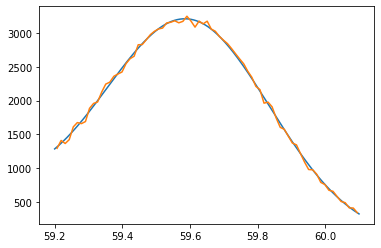

In [108]:
xs = np.linspace(59.2, 60.1, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45])
del xs, spline
print(roots[1] - roots[0])

In [541]:
clean_grade0_spectrum[1][4999]

59.999000499999994

In [532]:
line

<CompoundModel125(amplitude_0=22534.64651141, mean_0=59.60100535, stddev_0=0.25769821, slope_1=-5350.04403953, intercept_1=319200.21696186)>

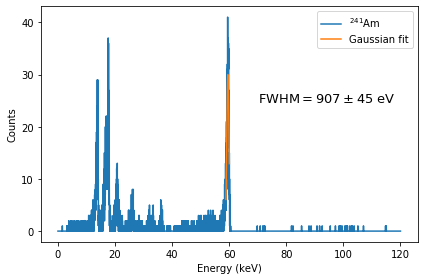

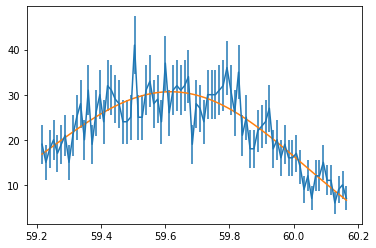

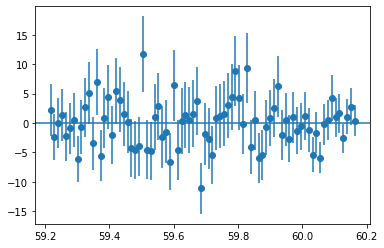

0.7125593090393374


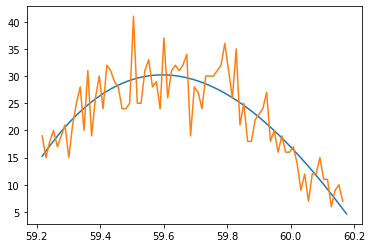

0.8087190278549699
Parameter('slope_1', value=-4.59189077963895)
Parameter('intercept_1', value=267.38340313300023)


In [98]:
i, j = 16, 14
cts, edges = np.histogram(h119_Am241._energy_map[j][i], bins=10000, range=(0.1, 120))
h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
                         fit_below=50, fit_above=50)
plt.show()
#print(i,j)
#fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=1113, upper=1190, energy=13.95,
#                                  plot=True, intercept=50, slope=-10)
fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=4930, upper=5010, plot=True)
            #fwhm_map[i][j] = fwhm*1000
#            fwhm_map_low[i][j] = fwhm*1000
        
#fwhm_map = np.ma.masked_equal(fwhm_map, 1)
#fwhm_map_low = np.ma.masked_equal(fwhm_map_low, 1)
print(line.slope_1)
print(line.intercept_1)

In [82]:
i, j = 17, 12
#fwhm_map = np.ones((32,32))
fwhm_map_low = np.ones((32,32))
for i in range(14,19):
    for j in range(12,17):
        if len(h119_Am241._energy_map[j][i]):
            cts, edges = np.histogram(h119_Am241._energy_map[j][i], bins=10000, range=(0.1, 120))
#h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
#                         fit_below=30, fit_above=40)
#plt.show()
            print(i,j)
            fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=1113, upper=1190, energy=13.95,
                                  plot=False, intercept=50, slope=-10)
            #fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=4930, upper=5000, plot=False)
            #fwhm_map[i][j] = fwhm*1000
            fwhm_map_low[i][j] = fwhm*1000
        
#fwhm_map = np.ma.masked_equal(fwhm_map, 1)
fwhm_map_low = np.ma.masked_equal(fwhm_map_low, 1)

14 12
1.2089852729604689
0.5219946624126148
14 13
1.102218523957294
0.47418585928722834
14 14
1.4311864096460174
0.4915909684597928
14 15
1.3507876292229473
0.49941299902094904
14 16
0.9392022191392317
0.5337862557846567
15 12
1.0289685109983542
0.4590769135321313
15 13
0.9870135599251079
0.4660335698617075
15 14
0.7774526972213177
0.4507142821310399
15 15
0.9351596510300936
0.46764456062709314
15 16
1.492315151731962
0.4504822981503285
16 12
1.0975646289777152
0.4851084657697271
16 13
0.8397062524153811
0.42778456914961005
16 14
1.0324720760449488
0.7146439352752889
16 15
0.9071679481279405
0.4676066737150393
16 16
0.9712475644002547
0.5178306000768007
17 12
1.058786515535197
0.43819738447079715
17 13
0.841906619436776
0.6378047246764211
17 15
1.236441750166276
0.4139904967512962
17 16
0.9562453150180932
0.4692696965844849
18 12
1.2899504282991703
0.4696399603054253
18 13
0.9578167741969315
0.6255145268374882
18 14
0.7468680652414322
0.5959428688130028
18 15
0.9049520362692686
0.52290

In [94]:
fwhm_map = np.ones((32,32))
for i in range(14,19):
    for j in range(12,17):
        if len(h119_Am241._energy_map[j][i]):
            cts, edges = np.histogram(h119_Am241._energy_map[j][i], bins=10000, range=(0.1, 120))

            print(i,j)
            fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=4925, upper=5000, plot=False)
            fwhm_map[i][j] = fwhm*1000
            
fwhm_map = np.ma.masked_equal(fwhm_map, 1)

14 12
0.8863041158937682
0.59530156271245
14 13
0.899280792846018
0.6239762898703844
14 14
0.8609773142629377
0.5974097815444068
14 15
1.5291371182552334
0.582684225555198
14 16
0.8609560558683764
0.629616742536669
15 12
0.8881009821684178
0.5717717763565062
15 13
0.80354241398278
0.6380074216194345
15 14
0.7716611675968228
0.6360690642161302
15 15
0.8808631259923165
0.6379855270057817
15 16
0.8298473521143981
0.5818544678227227
16 12
1.2109698914737637
0.6382792038553831
16 13
1.0347651949952519
0.5949936217766307
16 14
0.6645119562098571
0.8029115409020307
16 15
1.0188741437535298
0.5997623058359451
16 16
0.6438277739906901
0.6877423955302859
17 12
1.206531414933176
0.5555475494899937
17 13
1.0617380771523055
0.7372381803206665
17 15
1.112587386232103
0.5506196115692958
17 16
1.2006106073407536
0.5812662117450174
18 12
1.2987854773079908
0.5682513309850279
18 13
1.0764020476802862
0.6799183866649656
18 14
0.887461320166194
0.6485771351502265
18 15
0.5626361943031762
0.625712443992732

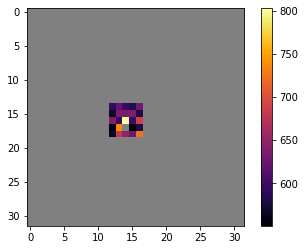

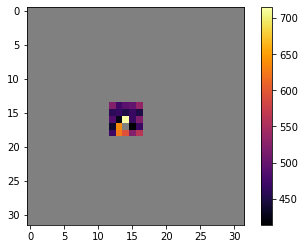

In [95]:
cmap = matplotlib.cm.get_cmap('inferno')
cmap.set_bad(color='gray')
plt.imshow(fwhm_map, cmap = cmap)
plt.colorbar()
plt.show()

cmap = matplotlib.cm.get_cmap('inferno')
cmap.set_bad(color='gray')
plt.imshow(fwhm_map_low, cmap = cmap)
plt.colorbar()
plt.show()

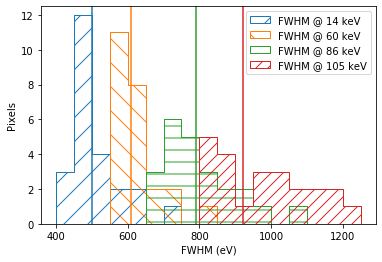

In [206]:
npzfile = np.load('eu155_data.npz')
fwhm_map_86 = npzfile['fwhm_map_86']
fwhm_map_105 = npzfile['fwhm_map_105']
fwhm_86 = npzfile['fwhm_86']
fwhm_105 = npzfile['fwhm_105']


#plt.hist(fwhm_map_low.data.flatten()[fwhm_map_low.data.flatten() > 1], histtype='step', label='FWHM @ 14 keV',
 #       bins=np.arange(400,1300,50))
cts, edges = np.histogram(fwhm_map_low.data.flatten()[fwhm_map_low.data.flatten() > 1], bins=np.arange(350, 1300, 50))
plt.fill_between(edges[1:], cts, step="pre", hatch="/", facecolor="none",
                 edgecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], linewidth=1, label='FWHM @ 14 keV')
plt.axvline(fwhm_14*1000, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])

cts, edges = np.histogram(fwhm_map.data.flatten()[fwhm_map.data.flatten() > 1], bins=np.arange(500,1300,50))
plt.fill_between(edges[1:], cts, step="pre", hatch="\\", facecolor="none",
                 edgecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], linewidth=1, label='FWHM @ 60 keV')
plt.axvline(fwhm_60*1000, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])


cts, edges = np.histogram(fwhm_map_86.flatten()[fwhm_map_86.flatten() > 1], bins=np.arange(600,1300,50))
plt.fill_between(edges[1:], cts, step="pre", hatch="-", facecolor="none",
                 edgecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], linewidth=1, label='FWHM @ 86 keV')
plt.axvline(fwhm_86*1000, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])

cts, edges = np.histogram(fwhm_map_105.flatten()[fwhm_map_105.flatten() > 1], bins=np.arange(750,1300,50))
plt.fill_between(edges[1:], cts, step="pre", hatch="//", facecolor="none",
                 edgecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][3], linewidth=1, label='FWHM @ 105 keV')
plt.axvline(fwhm_105*1000, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
plt.ylim(0,12.5)
plt.xlabel('FWHM (eV)')
plt.ylabel('Pixels')
plt.legend()
plt.savefig('pixel_fwhm_hist.pdf')
plt.show()

In [251]:
fwhm_map_low[14:19,12:17]
print(fwhm_map_low[17,15])
fwhm_map[14:19,12:17]
print(fwhm_map[17,15])
print(fwhm_map_86[17,15])
fwhm_map_105[14:19,12:17]
print(fwhm_map_105[17,15])
print(fwhm_map_105[15,16])

413.9904967512962
550.6196115692958
690.0236949637559
836.5681136203449
826.6635497077743


In [229]:
def fit_line(spec, lower=4920, upper=5010, energy=59.6, plot=True, intercept=1000, slope=-20):
    #upper=4995
    #lower=4930
    #lower=4920
    #upper=5010

    line_init = models.Gaussian1D(amplitude=np.max(spec[0]), mean=energy, stddev=0.3) + \
        models.Linear1D(slope=slope, intercept=intercept)
    fit_l = fitting.LevMarLSQFitter()
    line = fit_l(line_init, spec[1][lower:upper], spec[0][lower:upper])
    if plot:
        plt.errorbar(spec[1][lower:upper], spec[0][lower:upper],
             yerr=np.sqrt(spec[0][lower:upper]))
        plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]))
        plt.show()

        plt.errorbar(spec[1][lower:upper],
             spec[0][lower:upper] - line(spec[1][lower:upper]),
             yerr=np.sqrt(spec[0][lower:upper]),
             fmt='o'
            )
        plt.axhline(0)
        plt.show()
    
    screened_cts = np.maximum(spec[0][lower:upper], 1)

    chisq_red = np.sum(((spec[0][lower:upper] - line(spec[1][lower:upper])) ** 2)/
                   screened_cts)/len(spec[0][lower:upper] - 5)

    print(chisq_red)
    xs = np.linspace(spec[1][lower], spec[1][upper], int(1e6))
    spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
    roots = spline.roots() # find the roots
    if plot:
        plt.plot(xs, spline(xs)+line(xs).max()/2)
        plt.plot(spec[1][lower:upper],
         spec[0][lower:upper])
        plt.show()
    del xs, spline
    print(roots[1] - roots[0])
    return roots[1] - roots[0], line
    #print(line)

0.757551542403575
0.6152702123126375
0.9913506725486694
0.5053145376024482


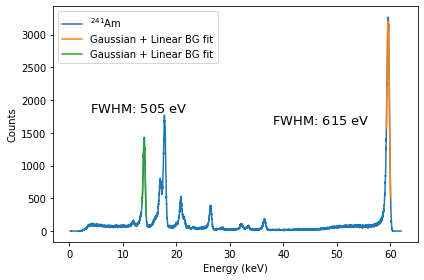

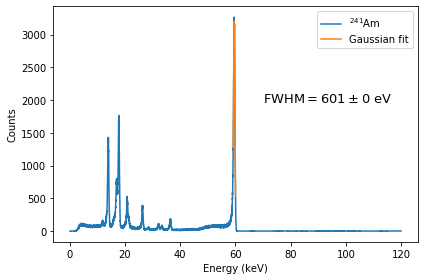

In [265]:
best_pixels = [(14, 12), (14, 14), (14, 15),
              (15, 16),
              (16, 13), (16, 15),
              (17, 12), (17, 15), (17, 16),
              (18, 12)]
#best_pixels = [(17, 12), (18, 12), (17, 15)]
best_energy_map = []
#for i, j in best_pixels:
for i in range(14,19):
    for j in range(12,17):
        best_energy_map += h119_Am241._energy_map[j][i]

cts, edges = np.histogram(best_energy_map, bins=10000, range=(0.1, 120))
spec = np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5])


lower=4933
upper=5000
fwhm, line = fit_line(spec, lower=lower, upper=upper, plot=False)

plt.plot(spec[1][(spec[1] < 62) & (spec[1] > 0)], spec[0][(spec[1] < 62) & (spec[1] > 0)], label='${}^{241}$Am')
plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]), label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)

lower=1120
upper=1190
fwhm, line = fit_line(spec, lower=lower, upper=upper, energy=14, plot=False)
plt.plot(spec[1][lower:upper],
         line(spec[1][lower:upper]),
         label='Gaussian + Linear BG fit')
plt.text(0.1, 0.55, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)


plt.legend()
#plt.title('10 Best Pixels Between (14, 12) and (18, 16), Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.show()
h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
                         fit_below=30, fit_above=40)
plt.show()


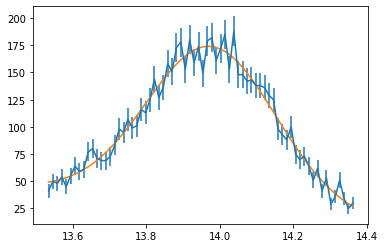

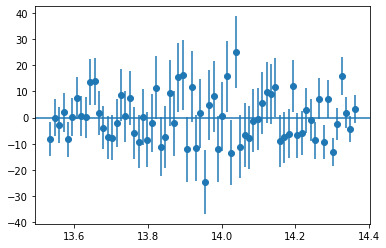

0.8574638100076426


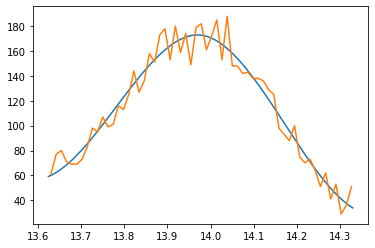

0.47988043276486536


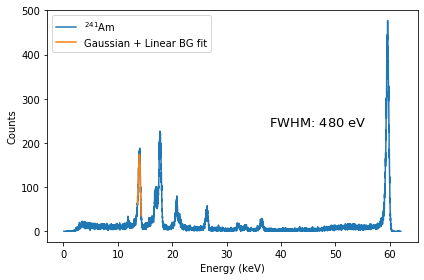

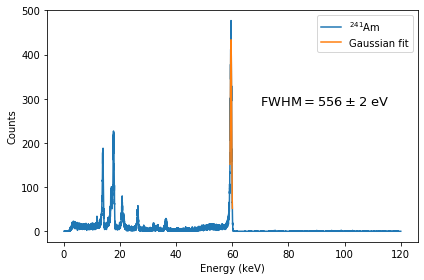

In [263]:
best_pixels = [(14, 12), (14, 14), (14, 15),
              (15, 16),
              (16, 13), (16, 15),
              (17, 12), (17, 15), (17, 16),
              (18, 12)]
best_pixels = [(17, 12), (18, 12), (17, 15)]
best_energy_map = []
for i, j in best_pixels:
    best_energy_map += h119_Am241._energy_map[j][i]

cts, edges = np.histogram(best_energy_map, bins=10000, range=(0.1, 120))
spec = np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5])

fwhm, line = fit_line(spec, lower=1120, upper=1190, energy=14)


plt.plot(spec[1][(spec[1] < 62) & (spec[1] > 0)], spec[0][(spec[1] < 62) & (spec[1] > 0)], label='${}^{241}$Am')
plt.plot(spec[1][(spec[1] < line.mean_0+line.stddev_0*2) & (spec[1] > line.mean_0-line.stddev_0*2)],
         line(spec[1][(spec[1] < line.mean_0+line.stddev_0*2) & (spec[1] > line.mean_0-line.stddev_0*2)]),
         label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.legend()
#plt.title('10 Best Pixels Between (14, 12) and (18, 16), Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.show()
h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
                         fit_below=30, fit_above=40)
plt.show()


In [ ]:
plt.hist([h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 0)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 1)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 2)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 3)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 4)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 4)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 4)]['PH']],
         np.arange(1, 6000), histtype='barstacked')
plt.savefig('energy_spectrum_Am241_17_14_by_grade.pdf')
plt.show()

plt.hist(other_data[pixel_mask(17, 14)]['GRADE'], bins=np.arange(14))
plt.show()

In [329]:
def pixel_mask(x, y):
    return (h119_Am241.raw_data_1d['RAWX'] == x) & (h119_Am241.raw_data_1d['RAWY'] == y)

(array([273194., 688292., 123790., 126533., 126325., 119965.,  21889.,
         16393.,  16344.,  19321.,  35172.,  18332.,  43519.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12.]),
 <a list of 13 Patch objects>)

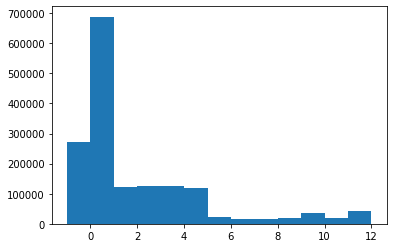

In [344]:
plt.hist(other_data['GRADE'], bins=13)

In [45]:
(other_data_2d['PH_RAW'] - other_data_2d['PH_OFF'])

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
file = fits.open("floodAm241_5C_-500V_20190815_small_region_capoffset_corrected.fits")

In [29]:
file[1].data

FITS_rec([(    0, -3.15964800e+08, 0, 0, -273.      , 15772331,  2, 409859, 1, 0, 0, 0, 0,  1935,  40967, 18, 1, 0, 0, -1515, 16, 783, [0, 0, 0, 0, 1, 0, 0, 0, 0], [ 6074,  6912,   828,  7122,  5913,   813,   835,   834,   824], [ 6064,  6932,   822,  7154, 10687,   793,   826,   828,   813], 0., 0, [ -10,   20,   -6,   32, 4774,  -20,   -9,   -6,  -11], [-1.000e+01,  2.000e+01, -6.000e+00,  3.200e+01,  4.774e+03, -2.000e+01, -9.000e+00, -6.000e+00, -1.100e+01], [-9.9787169e+00,  1.9957434e+01, -5.9872298e+00,  3.1931892e+01,  4.7638394e+03, -1.9957434e+01, -8.9808445e+00, -5.9872298e+00, -1.0976588e+01], [   0.      ,    0.      ,    0.      ,    0.      , 4765.087   ,    0.      ,    0.      ,    0.      ,    0.      ], 4765.087 , -60., -60., 0.),
          (    0, -3.15964800e+08, 0, 0, -273.      , 15772331,  6, 443368, 2, 0, 0, 0, 0,  7230, 482005, 16, 1, 0, 0,  -408, 15, 422, [0, 1, 0, 0, 1, 0, 0, 0, 0], [ 5547,  5773, 12002,  7081,  5281,  6389,  8712, 10027,  7410], [ 5549,  79

In [211]:
def tie_stddevs(model):
    return model.stddev_0

def tie_stddevs3(model):
    return model.stddev_3

def tie_means(model):
    return model.mean_0

def tie_means3(model):
    return model.mean_3

def exp_tail(x, norm=1, mean=0, stddev=1, slope=1):
    return norm*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))

def exp_tail_deriv(x, norm=1, mean=0, stddev=1, slope=1):
    return [
        np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*np.sqrt(2*np.pi)) -\
            norm*slope*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*(x-mean)*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*stddev*np.sqrt(2*np.pi)),
        norm*(x-mean)*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))
    ]

ExpTail = models.custom_model(exp_tail, fit_deriv=exp_tail_deriv)

def const_shelf(x, norm=1, mean=0, stddev=1):
    return norm*(1-scipy.stats.norm.cdf(x, mean, stddev))

def const_shelf_deriv(x, norm=1, mean=0, stddev=1):
    return [
        (1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev),
        norm*(x-mean)*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev**2)
    ]

ConstShelf = models.custom_model(const_shelf, fit_deriv=const_shelf_deriv)

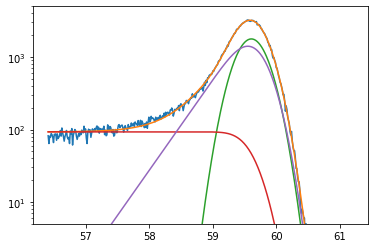

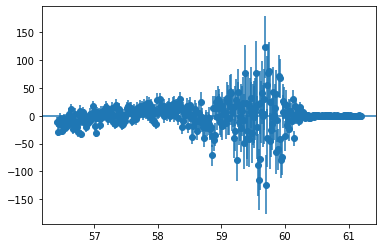

1.212483155881573
0.6091305888960576


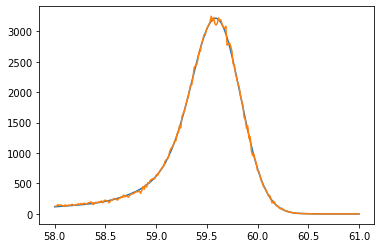

In [228]:
upper=5100
lower=4700

line_init = models.Gaussian1D(amplitude=3000, mean=60, stddev=0.2) + ConstShelf(norm=100, mean=105, stddev=0.4) + \
    ExpTail(norm=500, mean=105, stddev=0.4, slope=.1)# + models.Const1D(amplitude=20)

line_init.amplitude_0.min = 0
line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
line_init.norm_1.min = 0
line_init.norm_1.max = None
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means
line_init.norm_2.min = 0
line_init.norm_2.max = None

fitter = fitting.LevMarLSQFitter()
line = fitter(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))

plt.plot(clean_grade0_spectrum[1][lower:upper], line[0](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[1](clean_grade0_spectrum[1][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line[2](clean_grade0_spectrum[1][lower:upper]))
#plt.plot(clean_grade0_spectrum[1][lower:upper], line[3](clean_grade0_spectrum[1][lower:upper]))
plt.semilogy()
plt.ylim(5,5000)
plt.show()

plt.errorbar(clean_grade0_spectrum[1][lower:upper],
             clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper]),
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]),
             fmt='o'
            )
plt.axhline(0)
plt.show()

screened_cts = np.maximum(clean_grade0_spectrum[0][lower:upper], 1)

chisq_red = np.sum(((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2)/\
                   screened_cts)/len(clean_grade0_spectrum[0][lower:upper] - 6)
print(chisq_red)

xs = np.linspace(58, 61, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 59.5) < 1.5],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 59.5) < 1.5])
del xs, spline
print(roots[1] - roots[0])
fwhm_60 = roots[1] - roots[0]
line_60 = line

In [213]:
import scipy.stats

In [253]:
plt.scatter(other_data["PH_COM"], other_data["PH_TR"] - other_data["PH_COM"])
plt.show()

KeyError: 'PH_COM'

In [260]:
z_com_mask = other_data_2d['PH_COM'] == 0

In [266]:
plt.scatter(other_data_2d['PH_TR'].loc[~z_com_mask].sum(axis=1), other_data_2d['PH_TR'].loc[z_com_mask].sum(axis=1))

ValueError: Cannot index with multidimensional key

In [273]:
other_data_2d['PH_TR'].loc[pd.Index(other_data_2d['PH_COM'] == 0)]

KeyError: "None of [Index([ True, False,  True,  True, False,  True,  True,  True,  True,  True,\n       False,  True, False, False,  True,  True,  True,  True,  True,  True,\n        True,  True, False,  True,  True,  True,  True,  True,  True,  True,\n        True, False, False,  True,  True,  True,  True,  True,  True,  True,\n       False,  True,  True,  True,  True,  True,  True,  True,  True, False,\n        True,  True,  True,  True,  True,  True,  True, False, False,  True,\n        True,  True,  True,  True,  True,  True,  True, False,  True,  True,\n        True,  True,  True,  True,  True,  True, False,  True,  True,  True,\n        True,  True, False,  True, False, False, False,  True, False,  True,\n       ...\n        True,  True,  True,  True, False,  True,  True,  True,  True,  True,\n        True,  True,  True, False, False,  True,  True,  True,  True, False,\n        True, False, False,  True,  True,  True,  True,  True,  True,  True,\n        True, False,  True,  True,  True,  True,  True,  True,  True,  True,\n       False,  True,  True,  True,  True,  True, False,  True, False, False,\n       False,  True, False,  True,  True,  True,  True,  True, False,  True,\n        True,  True,  True,  True,  True,  True,  True, False,  True,  True,\n        True,  True,  True,  True,  True,  True, False,  True,  True,  True,\n        True,  True,  True,  True,  True, False,  True,  True,  True,  True],\n      dtype='object', length=1629069)] are in the [index]"

In [272]:
import pandas as pd

In [ ]:
plt.scatter(other_data_2d['PH_TR'].mask(~grade_mask).mask(z_com_mask).sum(axis=1),
            other_data_2d['PH_TR'].mask(~grade_mask).mask(~z_com_mask).mean(axis=1), marker=',', s=1)
#plt.ylim(-250, 50)
#plt.xlim(0,6000)
plt.show()

In [285]:
other_data_2d['PH_TR'].mask(~grade_mask).mask(z_com_mask)

,0,1,2,3,4,5,6,7,8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,4775.638184,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1441.484741,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,1706.474854,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,2142.333496,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,492.157867,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
